In this notebook, we compare some out of the box models to the ELM prior with respect to our set of constraints

In [1]:
import pickle
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from periodictable import elements

In [2]:
from exfor_tools import curate, quantities, reaction

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [3]:
from jitr import data_dir, rmatrix
from jitr.optical_potentials import kduq, wlh
from jitr.utils import kinematics
from jitr.xs.elastic import DifferentialWorkspace

In [4]:
import elm

In [5]:
proton = (1, 1)
neutron = (1, 0)

## Load constraints and workspaces

In [6]:
with open("./constraints.pkl", "rb") as f:
    constraints = pickle.load(f)

## Parameters

### ELM prior

In [7]:
with open("../prior/prior_distribution.pickle", "rb") as f:
    prior = pickle.load(f)

In [8]:
prior_samples = prior.rvs(size=1000)

In [9]:
prior_samples = [
    OrderedDict([(p.name, v) for p, v in zip(elm.params, sample)])
    for sample in prior_samples
]

## kduq

In [10]:
kd_samples = {
    proton: kduq.get_samples_federal(proton),
    neutron: kduq.get_samples_federal(neutron),
}

In [11]:
def kduq_calculate_xs(workspace: DifferentialWorkspace, params: OrderedDict):
    coul, cen, so = kduq.calculate_params(
        tuple(workspace.reaction.projectile),
        tuple(workspace.reaction.target),
        workspace.kinematics.Elab,
        params,
    )
    return workspace.xs(
        interaction_central=kduq.central_plus_coulomb,
        interaction_spin_orbit=kduq.spin_orbit,
        args_central=(cen, coul),
        args_spin_orbit=so,
    )

## WLH

In [12]:
wlh_samples = {proton: wlh.get_samples(proton), neutron: wlh.get_samples(neutron)}

In [13]:
def wlh_calculate_xs(workspace: DifferentialWorkspace, params: OrderedDict):
    coul, cen, so = wlh.calculate_params(
        tuple(workspace.reaction.projectile),
        tuple(workspace.reaction.target),
        workspace.kinematics.Elab,
        params,
    )
    return workspace.xs(
        interaction_central=wlh.central_plus_coulomb,
        interaction_spin_orbit=wlh.spin_orbit,
        args_central=(cen, coul),
        args_spin_orbit=so,
    )

# Run UQ

In [14]:
class UQResult:
    def __init__(self, model, constraint, func, params):
        self.intervals =  np.arange(5, 100, 5)
        xvis = model.visualization_workspace.angles
        ndof = constraint.n_data_pts
        xs_vis = np.zeros((len(params), len(xvis)))
        xs_cal = np.zeros((len(params), ndof))

        self.residuals = np.zeros((len(params), len(constraint.x)))
        self.chi2 = np.zeros((len(params)))
        for i in range(len(params)):
            # calibration stuff
            ym = model(func, params[i])
            self.residuals[i, :] = constraint.residual(ym)
            self.chi2[i] = constraint.chi2(ym)
            xs_cal[i, :] = ym
    
            # visualization stuff
            xs_vis[i, :] = model.get_quantity_vis(
                func,
                params[i],
            )

        self.ci = np.percentile(xs_cal, self.intervals, axis=0)
        self.visual_confidence_intervals = np.percentile(xs_vis, [16, 84], axis=0)

In [15]:
results_kduq = {}
results_wlh = {}
results_elm = {}

for rxn in tqdm(list(constraints.keys())[:2]):
    results_kduq[rxn] = []    
    results_wlh[rxn] = []
    results_elm[rxn] = []

    for constraint, model in constraints[rxn]:
        results_kduq[rxn].append(
            UQResult(
                model, constraint, kduq_calculate_xs, kd_samples[tuple(rxn.projectile)]
            )
        )
        results_wlh[rxn].append(
            UQResult(
                model, constraint,  wlh_calculate_xs, wlh_samples[tuple(rxn.projectile)]
            )
        )        
        results_elm[rxn].append(
            UQResult(
                model, constraint, elm.calculate_diff_xs, prior_samples
            )
        )

  0%|                                                                         | 0/2 [00:00<?, ?it/s]/home/beyerk/Projects/jitr/src/jitr/optical_potentials/kduq.py:302: RuntimeWarning: overflow encountered in exp
  1 + np.exp((A - params["d2_A3"]) / params["d2_A2"])
100%|████████████████████████████████████████████████████████████████| 2/2 [09:32<00:00, 286.28s/it]


NameError: name 'xvis' is not defined

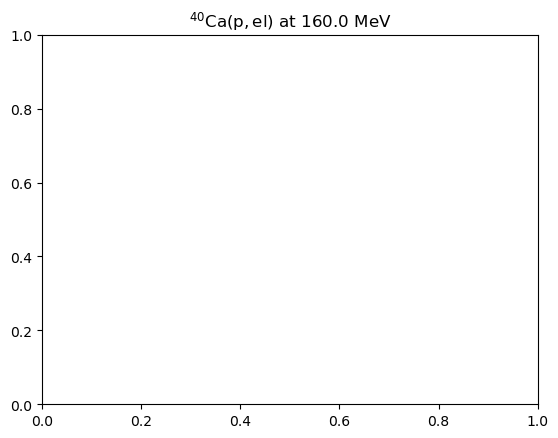

In [16]:
plt.title(f"${model.reaction.reaction_latex}$ at {model.kinematics.Elab} MeV")
plt.fill_between(
    xvis, kduq_confint_vis[1], kduq_confint_vis[0], alpha=0.5, label="KDUQ"
)
plt.fill_between(xvis, wlh_confint_vis[1], wlh_confint_vis[0], alpha=0.5, label="WLH")
plt.fill_between(
    xvis, elm_confint_vis[1], elm_confint_vis[0], alpha=0.5, label="ELM Prior"
)

plt.errorbar(
    constraint.x,
    constraint.y,
    constraint.stat_err_y,
    linestyle="none",
    marker=".",
    color="k",
)

plt.yscale("log")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$d \sigma/d\Omega$ [b/Sr]")
plt.legend()

In [ ]:
plt.title(f"${model.reaction.reaction_latex}$ at {model.kinematics.Elab} MeV")
plt.ylabel("frequency")
plt.xlabel(r"$\chi^2 / \,\rm{DOF}$")
plt.hist(kduq_chi2 / ndof, label="KDUQ", bins=17, density=True, alpha=0.7)
plt.hist(wlh_chi2 / ndof, label="WLH", bins=17, density=True, alpha=0.7)
plt.legend()